In [15]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_distribution

import os
from dotenv import load_dotenv

In [2]:
# Create a quantum circuit with two qubits
qr = QuantumRegister(2, 'q')
qc = QuantumCircuit(qr)

# Apply Hadamard gate to the first qubit
qc.h(0)
# Superposition of |00> and |10>
# Create the entangled state applying CNOT gate with first qubit as control, second as target
qc.cx(0, 1)  

# Measure both qubits
qc.measure_all()

Quantum circuit to create an entangled state:
        ┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1 


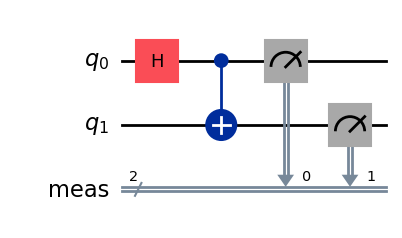

In [3]:
# Visualize the circuit
print("Quantum circuit to create an entangled state:")
print(qc.draw())
qc.draw(output="mpl", plot_barriers=False)

In [4]:
load_dotenv(dotenv_path="../.env")
ibm_token = os.getenv("IBM_TOKEN")

In [5]:
# Set up the IBM Quantum service
QiskitRuntimeService.save_account(channel="ibm_quantum",
								  token=ibm_token, overwrite=True,
								  set_as_default=True)
service = QiskitRuntimeService()

In [6]:
# Select a real backend
backend = service.least_busy(operational=True, simulator=False)
print(f"Using backend: {backend.name}")

Using backend: ibm_brisbane


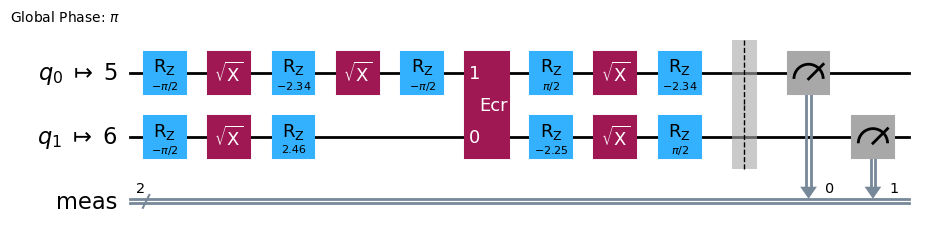

In [23]:
target = backend.target
pass_manager = generate_preset_pass_manager(target=target, optimization_level=2, backend=backend)

# Transpile it by calling the run method of the pass manager
transpiled = pass_manager.run(qc)
 
# Draw it, excluding idle qubits from the diagram
transpiled.draw("mpl", idle_wires=False, style="iqp")

In [24]:
# Here we can configure the sample, such as:
# sampler.options.default_shots = 500
sampler = Sampler(mode=backend)

# Turn on dynamical decoupling
sampler.options.dynamical_decoupling.enable = True
# Turn on gate twirling. Requires qiskit_ibm_runtime 0.23.0 or later.
sampler.options.twirling.enable_gates = True

# Create a job
job = sampler.run([transpiled], shots=500)
job_id = job.job_id()
print(job_id)

cvmanxfm2dg0008dpfe0


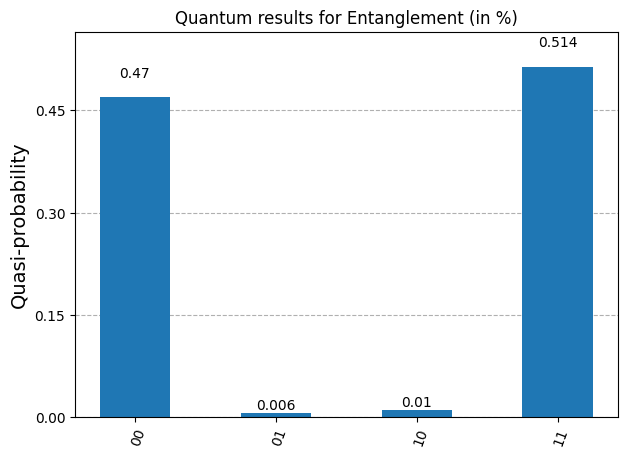

In [25]:
# Create histogram from job result
result = job.result()
dist = result[0].data.meas.get_counts()
plot_distribution(dist, title="Quantum results for Entanglement (in %)")

In [26]:
print("Counts:", dist)

Counts: {'00': 235, '10': 5, '11': 257, '01': 3}


*The presence of '10' and '01' states in the entanglement experiment, which theoretically should only produce '00' and '11' states, can be attributed to several factors in real quantum hardware:*

- **Quantum Noise:** Environmental interference that disrupts the quantum state.
- **Decoherence:** The gradual loss of quantum information due to interaction with the environment.
- Gate Errors: Imperfections in the application of quantum gates (Hadamard and CNOT in this case).
- Measurement Errors: Inaccuracies in the readout process of qubit states.
- Limited Coherence Time: The quantum state degrading before measurement is completed.
- Crosstalk: Unwanted interactions between qubits or control lines.
- Imperfect Initialization: Qubits not starting in a perfect |0⟩ state.
- Thermal Excitations: Random state flips due to energy fluctuations.